#  Real-Estate Price Forecasting with Explainable ML
**Checklist implemented:**
- Full lifecycle: Data → Preprocessing → Model → Evaluation → Deployment  
- In-depth EDA: distributions, outliers, correlations, missingness, feature-target trends  
- Feature engineering (derived features + ordinal handling)  
- Baseline & advanced models (RF, GBM) + Optuna tuning  
- Proper regression metrics + visualizations (RMSE, MAE, MAPE, R², residuals)  
- Error analysis + interpretability (feature importance, permutation, SHAP, LIME fallback)  
- Save pipeline artifact for Flask UI: `pipeline.joblib`

In [ ]:
import sys, platform, warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, joblib
from datetime import datetime

# sklearn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("pandas:", pd.__version__, "scikit-learn:", sklearn.__version__)


Python: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
pandas: 2.3.2 scikit-learn: 1.7.2


In [ ]:
import os

csv_path = "train.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found in working directory. Upload it or change csv_path.")

df = pd.read_csv(csv_path)
print("Full dataset shape:", df.shape)
display(df.head())

column_mapping = {
    "GrLivArea": "SquareFeet",
    "BedroomAbvGr": "Bedrooms",
    "FullBath": "Bathrooms",
    "YearBuilt": "YearBuilt",
    "LotArea": "LotSize",
    "Neighborhood": "Neighborhood",
    "HouseStyle": "HouseStyle",
    "Exterior1st": "Exterior",
    "KitchenQual": "KitchenQuality",
    "SalePrice": "SalePrice"
}

missing_keys = [k for k in column_mapping.keys() if k not in df.columns]
if missing_keys:
    raise KeyError(f"The following expected columns are missing in train.csv: {missing_keys}")

df_selected = df[list(column_mapping.keys())].rename(columns=column_mapping)
print("df_selected created with columns:", df_selected.columns.tolist())
display(df_selected.head())

Full dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


df_selected created with columns: ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'LotSize', 'Neighborhood', 'HouseStyle', 'Exterior', 'KitchenQuality', 'SalePrice']


,SquareFeet,Bedrooms,Bathrooms,YearBuilt,LotSize,Neighborhood,HouseStyle,Exterior,KitchenQuality,SalePrice
0,1710,3,2,2003,8450,CollgCr,2Story,VinylSd,Gd,208500
1,1262,3,2,1976,9600,Veenker,1Story,MetalSd,TA,181500
2,1786,3,2,2001,11250,CollgCr,2Story,VinylSd,Gd,223500
3,1717,3,1,1915,9550,Crawfor,2Story,Wd Sdng,Gd,140000
4,2198,4,2,2000,14260,NoRidge,2Story,VinylSd,Gd,250000


Shape: (1460, 10)

Data types:


SquareFeet         int64
Bedrooms           int64
Bathrooms          int64
YearBuilt          int64
LotSize            int64
Neighborhood      object
HouseStyle        object
Exterior          object
KitchenQuality    object
SalePrice          int64
dtype: object


Summary statistics:


,count,mean,std,min,25%,50%,75%,max
SquareFeet,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
Bedrooms,1460.0,2.866438,0.815778,0.0,2.0,3.0,3.00,8.0
Bathrooms,1460.0,1.565068,0.550916,0.0,1.0,2.0,2.00,3.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.0,1973.0,2000.00,2010.0
LotSize,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0



Missing values per column:


SquareFeet        0
Bedrooms          0
Bathrooms         0
YearBuilt         0
LotSize           0
Neighborhood      0
HouseStyle        0
Exterior          0
KitchenQuality    0
SalePrice         0
dtype: int64

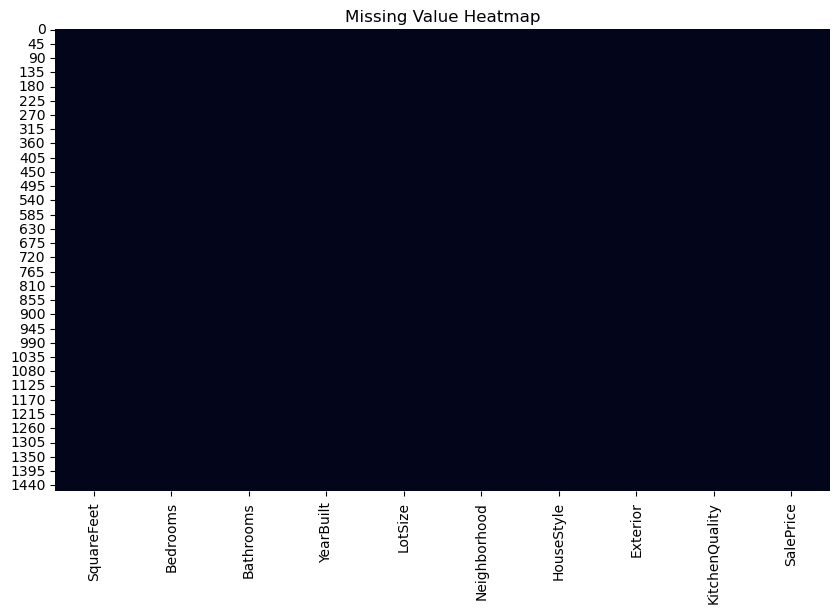

In [ ]:
print("Shape:", df_selected.shape)

print("\nData types:")
display(df_selected.dtypes)

print("\nSummary statistics:")
display(df_selected.describe().T)

print("\nMissing values per column:")
missing = df_selected.isnull().sum().sort_values(ascending=False)
display(missing)

plt.figure(figsize=(10,6))
sns.heatmap(df_selected.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()


Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


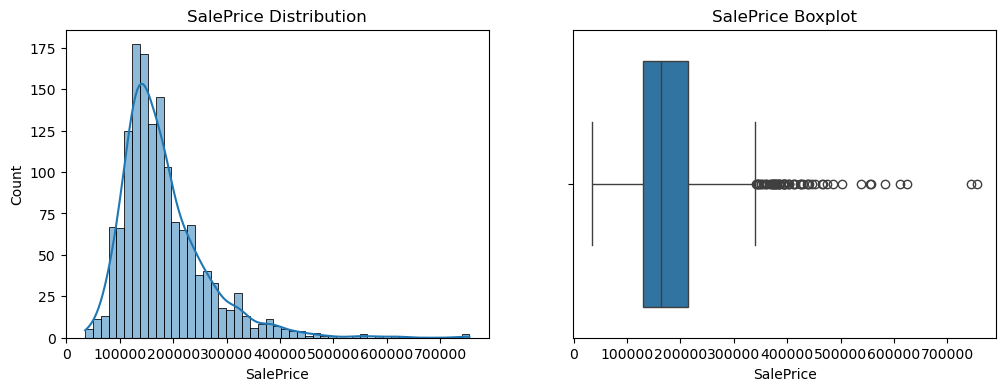

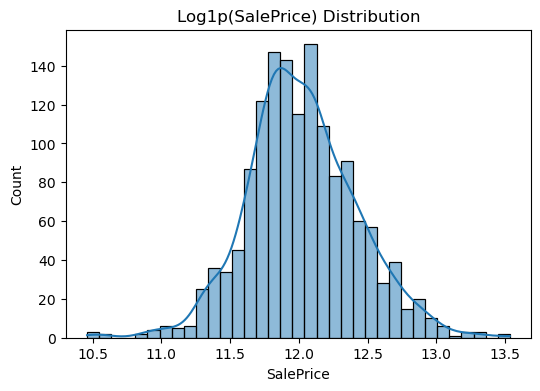

In [ ]:
target = 'SalePrice'

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_selected[target], kde=True, ax=axes[0])
axes[0].set_title("SalePrice Distribution")

sns.boxplot(x=df_selected[target], ax=axes[1])
axes[1].set_title("SalePrice Boxplot")

print("Skewness:", df_selected[target].skew())
print("Kurtosis:", df_selected[target].kurt())

plt.show()

plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df_selected[target]), kde=True)
plt.title("Log1p(SalePrice) Distribution")
plt.show()


Numeric columns: ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'LotSize']


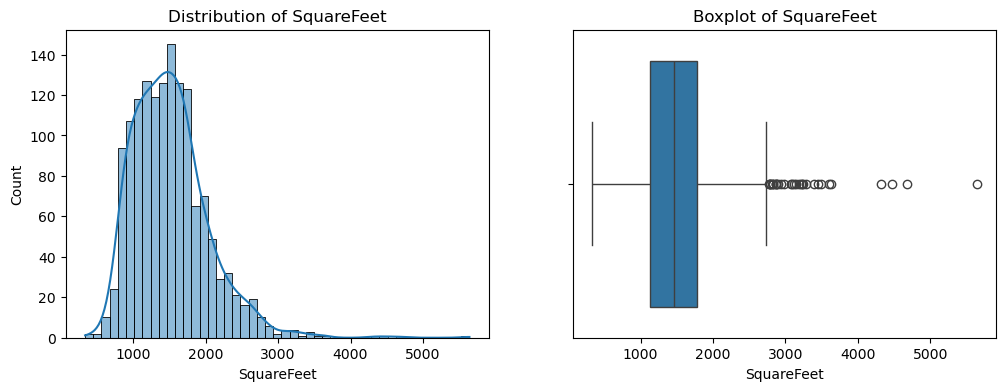

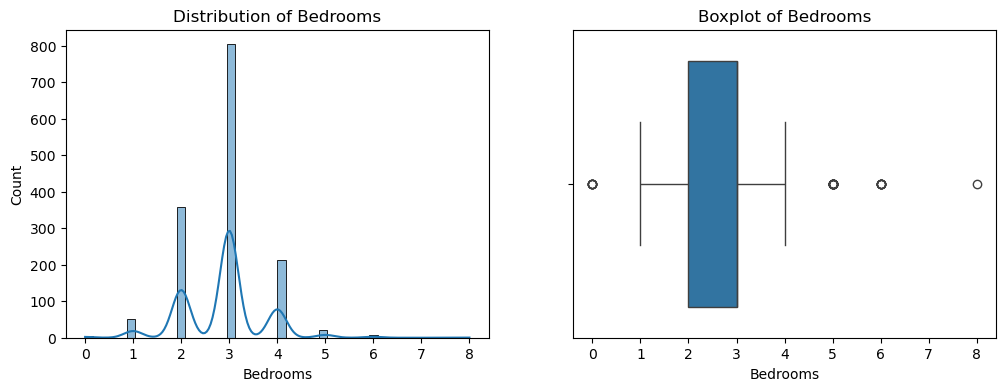

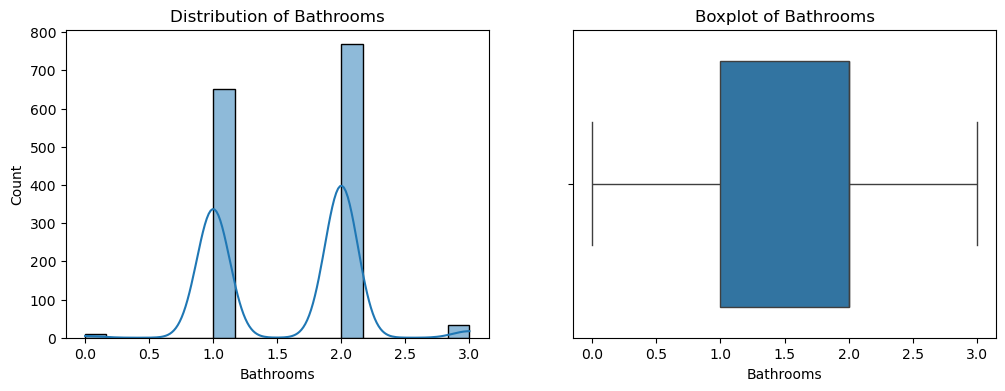

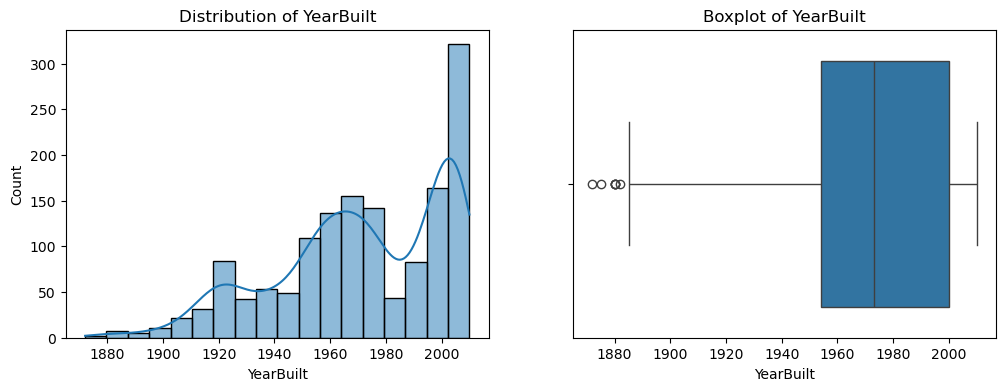

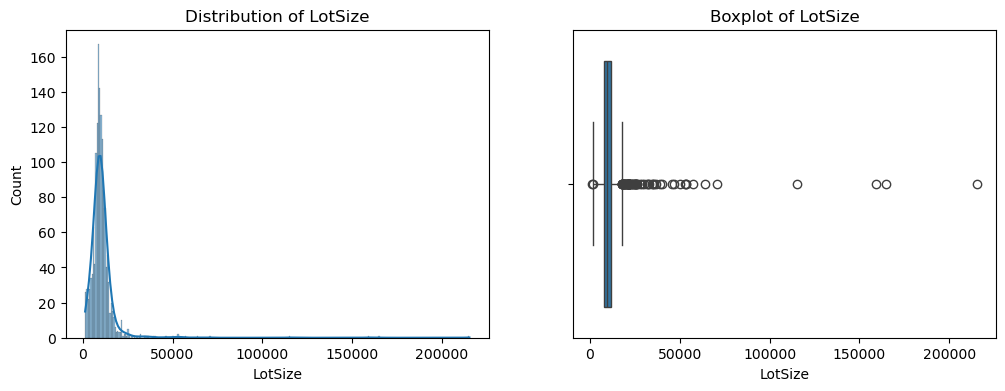

In [ ]:
# selecting numeric columns excluding the target
num_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('SalePrice')

print("Numeric columns:", num_cols)

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(df_selected[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')

    sns.boxplot(x=df_selected[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')

    plt.show()


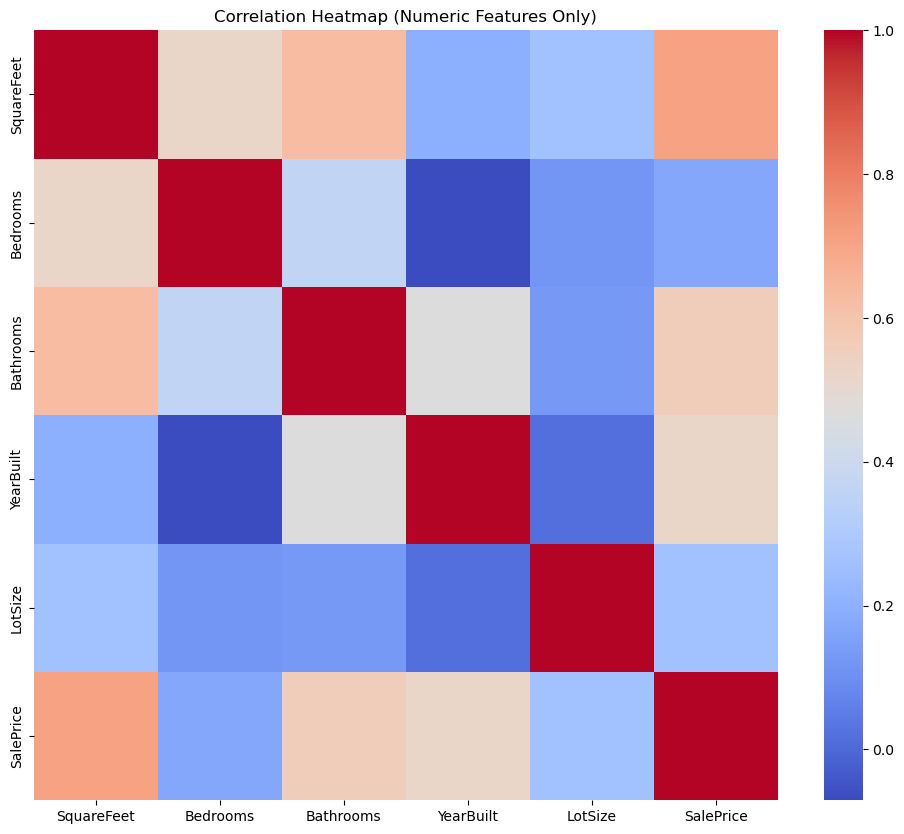

Top correlations with SalePrice:


SalePrice     1.000000
SquareFeet    0.708624
Bathrooms     0.560664
YearBuilt     0.522897
LotSize       0.263843
Bedrooms      0.168213
Name: SalePrice, dtype: float64

In [ ]:
numeric_df = df_selected.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

corr_target = corr['SalePrice'].abs().sort_values(ascending=False)
print("Top correlations with SalePrice:")
display(corr_target)


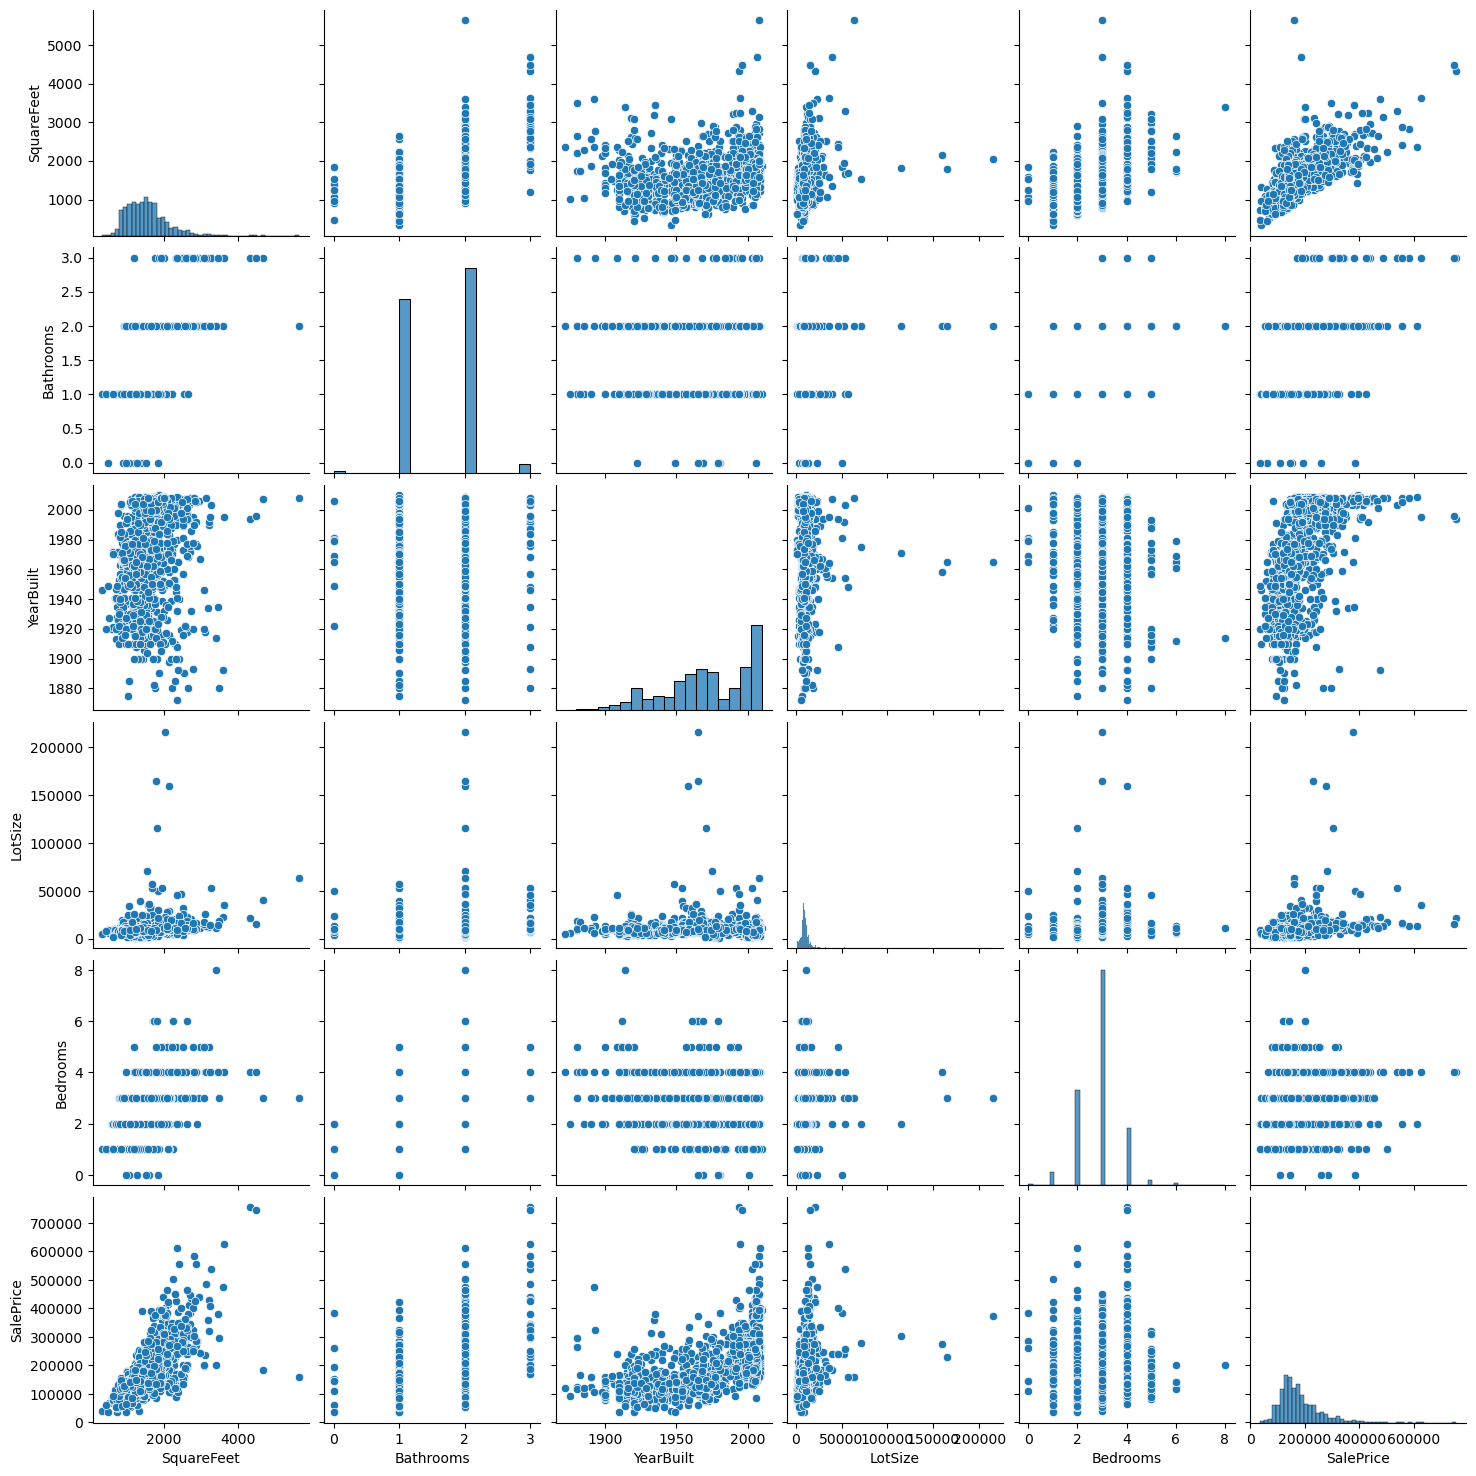

In [ ]:
#  Pairplots (top numeric features vs SalePrice) 
numeric_df = df_selected.select_dtypes(include=[np.number])

corr_target = numeric_df.corr()['SalePrice'].abs().sort_values(ascending=False)
top_numeric = corr_target.index[1:6].tolist()  

sns.pairplot(df_selected[top_numeric + ['SalePrice']])
plt.show()

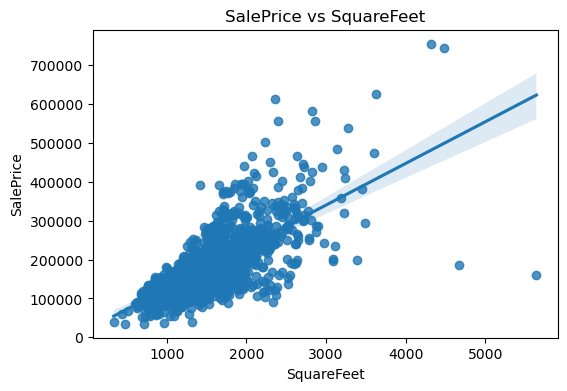

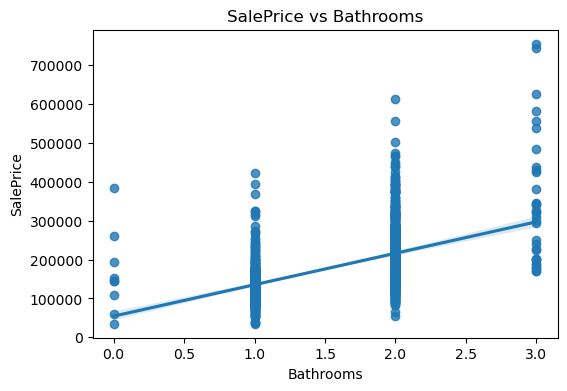

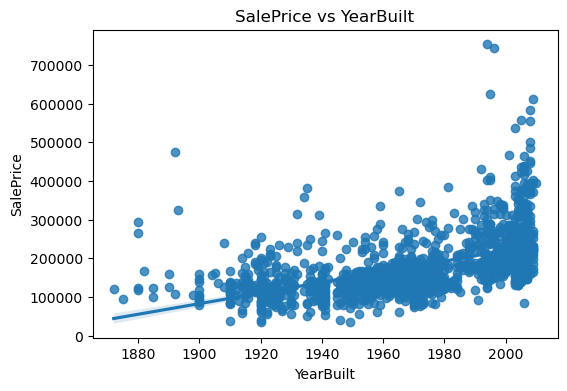

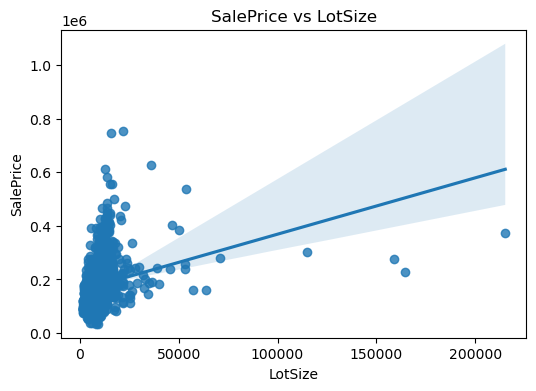

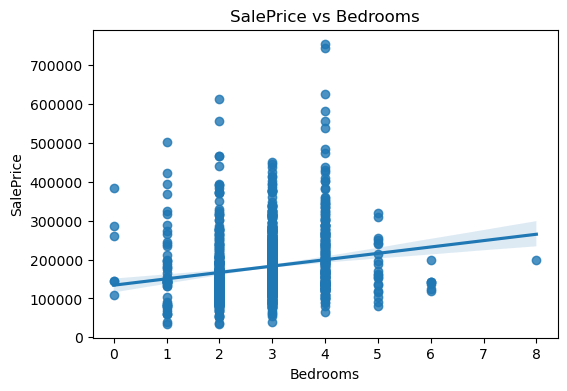

In [ ]:
# Feature-target scatter + regression line
for col in top_numeric:
    plt.figure(figsize=(6,4))
    sns.regplot(x=df_selected[col], y=df_selected['SalePrice'])
    plt.title(f'SalePrice vs {col}')
    plt.show()


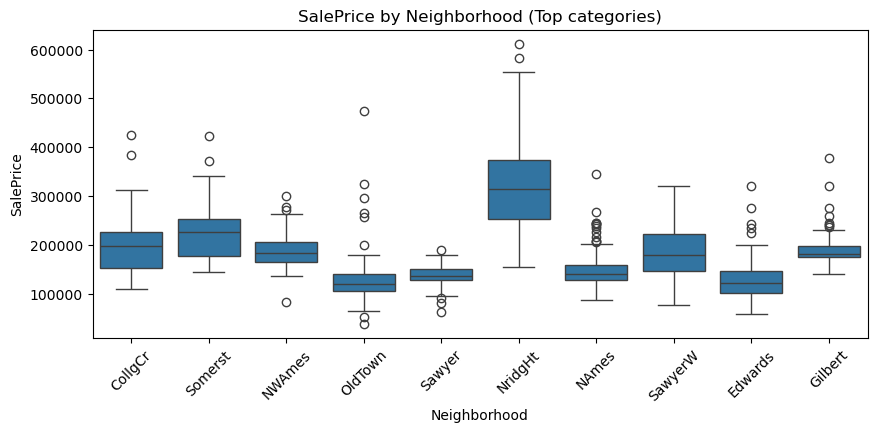

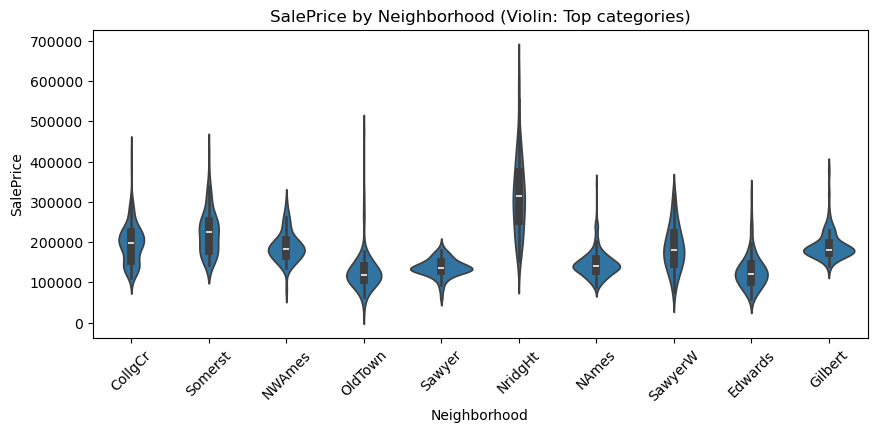

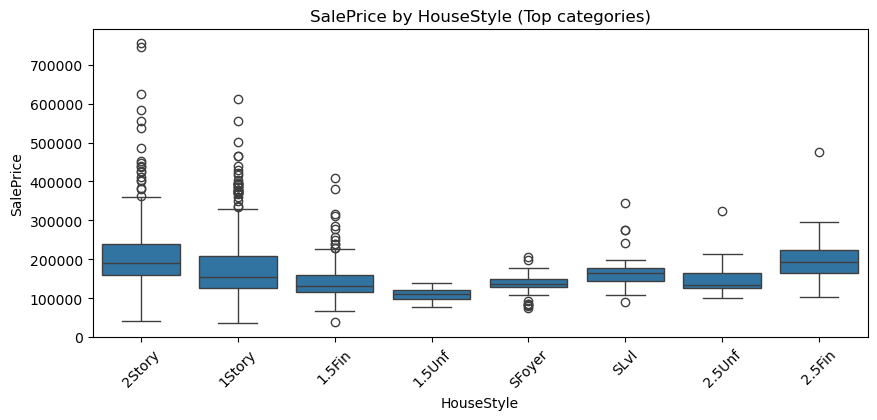

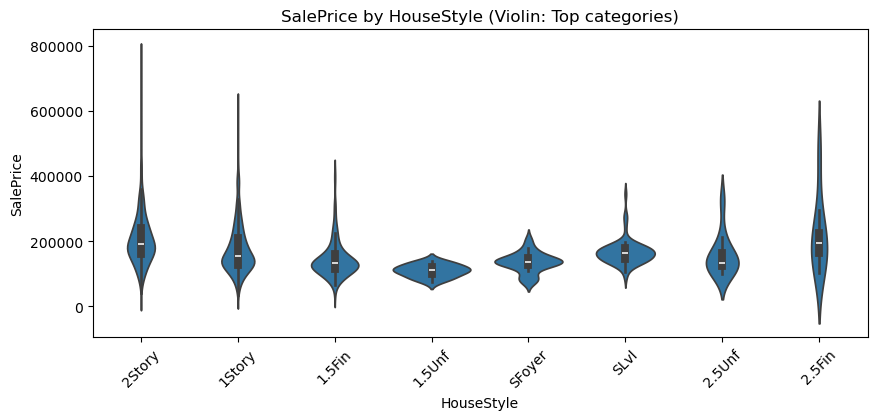

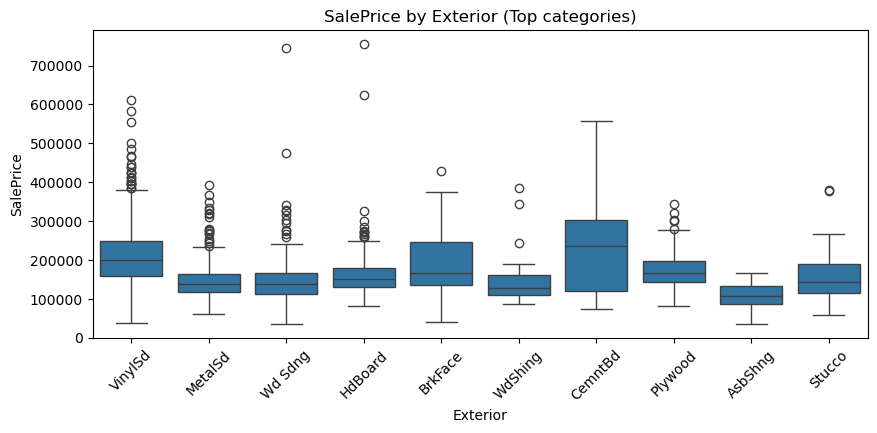

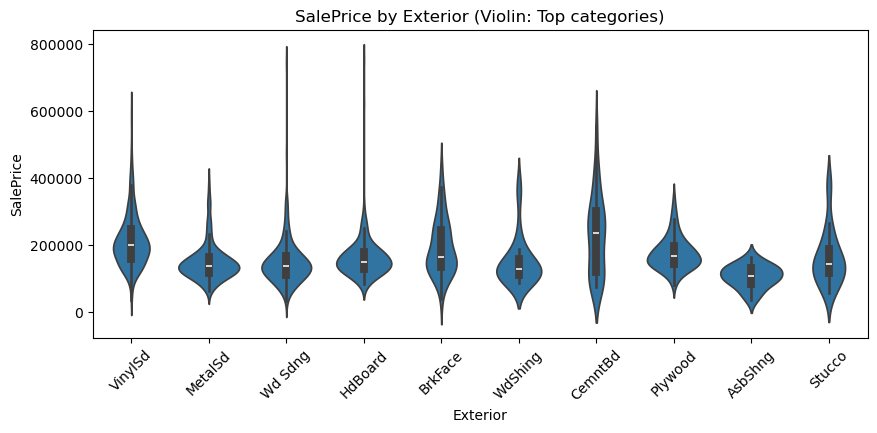

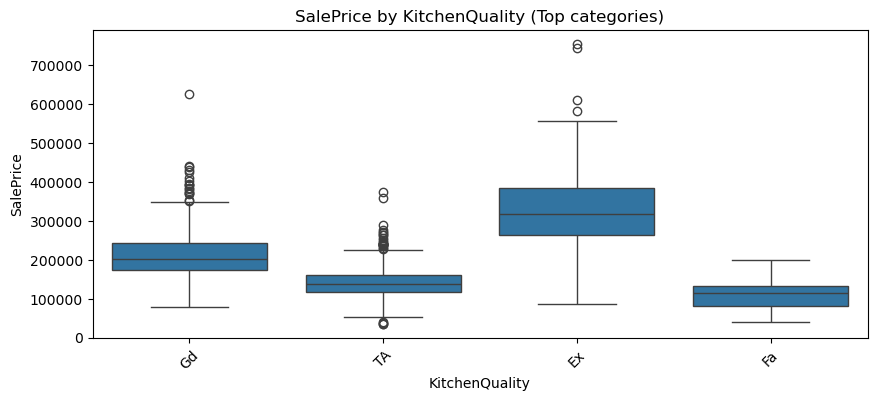

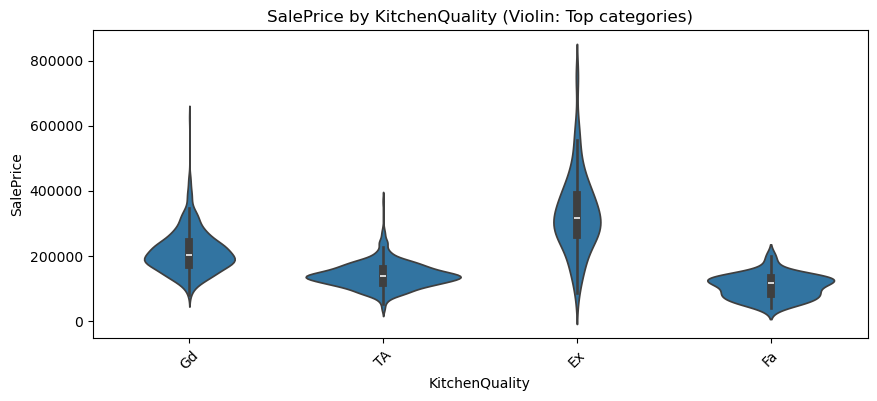

In [ ]:
#  Boxplots for categorical features vs SalePrice

# Recompute categorical columns in case kernel restarted
cat_cols = df_selected.select_dtypes(include=['object','category']).columns.tolist()

for col in cat_cols:
    top_levels = df_selected[col].value_counts().head(10).index

    # Boxplot
    plt.figure(figsize=(10,4))
    sns.boxplot(
        x=df_selected[col].where(df_selected[col].isin(top_levels)),
        y=df_selected['SalePrice']
    )
    plt.title(f'SalePrice by {col} (Top categories)')
    plt.xticks(rotation=45)
    plt.show()

    # Violin plot
    plt.figure(figsize=(10,4))
    sns.violinplot(
        x=df_selected[col].where(df_selected[col].isin(top_levels)),
        y=df_selected['SalePrice']
    )
    plt.title(f'SalePrice by {col} (Violin: Top categories)')
    plt.xticks(rotation=45)
    plt.show()

Outliers detected using Z-score (>3):


SquareFeet    16
Bedrooms      14
Bathrooms      0
YearBuilt      6
LotSize       13
dtype: int64

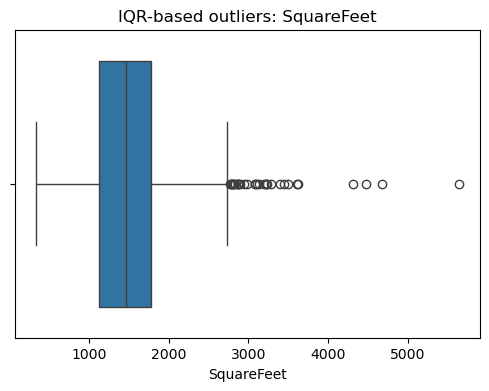

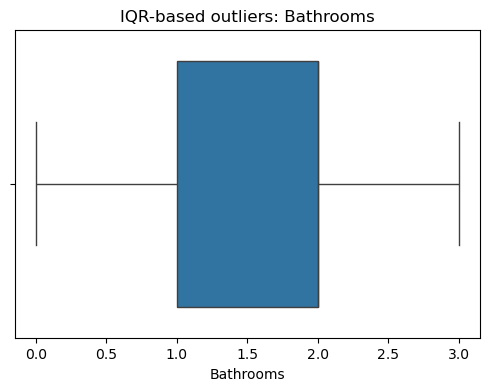

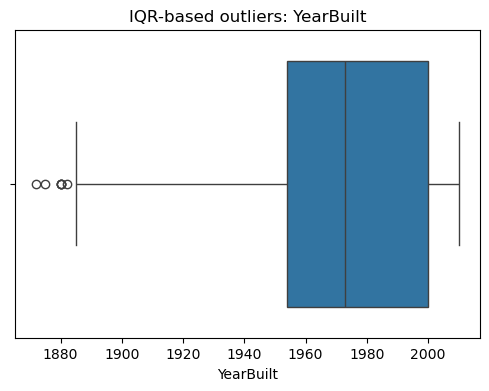

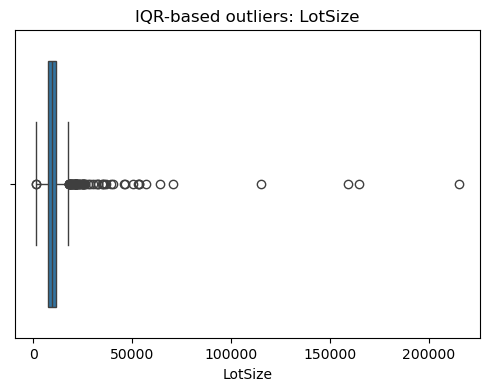

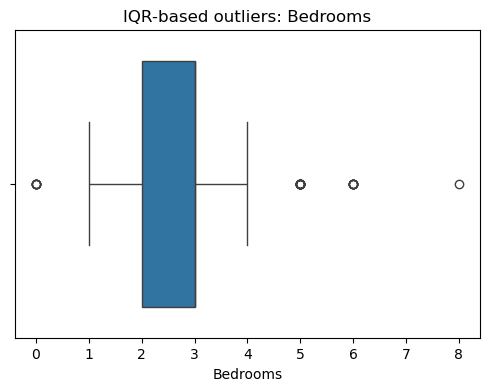

In [ ]:
#  Outlier analysis (Z-score)
from scipy import stats

z_df = df_selected[num_cols].apply(lambda x: np.abs(stats.zscore(x)))
outlier_counts_z = (z_df > 3).sum()
print("Outliers detected using Z-score (>3):")
display(outlier_counts_z)

# IQR range visualization
for col in top_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df_selected[col])
    plt.title(f'IQR-based outliers: {col}')
    plt.show()


In [ ]:
#VIF (Variance Inflation Factor)
# VIF checks if a feature is too similar to other features. High VIF = high similarity (multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = num_cols
vif_data["VIF"] = [variance_inflation_factor(df_selected[num_cols].values, i)
                   for i in range(len(num_cols))]

print("Variance Inflation Factor (VIF):")
display(vif_data.sort_values("VIF", ascending=False))


Variance Inflation Factor (VIF):


,Feature,VIF
0,SquareFeet,19.469373
1,Bedrooms,18.084477
3,YearBuilt,16.761371
2,Bathrooms,15.396408
4,LotSize,2.274477


In [ ]:

import numpy as np
import pandas as pd

print("==========================================")
print("🔍 1. DATASET OVERVIEW")
print("==========================================")
print("Shape:", df_selected.shape)
print("\nData Types:\n", df_selected.dtypes)
print("\nBasic Stats:\n", df_selected.describe().T)

print("\n==========================================")
print("🔍 2. MISSING VALUE ANALYSIS")
print("==========================================")
missing = df_selected.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) == 0:
    print("No missing values detected.")
else:
    print("Columns with missing values:\n", missing)

print("\n==========================================")
print("🔍 3. TARGET VARIABLE (SalePrice) SUMMARY")
print("==========================================")
print("Mean:", df_selected["SalePrice"].mean())
print("Median:", df_selected["SalePrice"].median())
print("Std Dev:", df_selected["SalePrice"].std())
print("Min:", df_selected["SalePrice"].min())
print("Max:", df_selected["SalePrice"].max())
print("Skewness:", df_selected["SalePrice"].skew())
print("Kurtosis:", df_selected["SalePrice"].kurt())

print("\n==========================================")
print("🔍 4. UNIVARIATE ANALYSIS — NUMERIC FEATURES")
print("==========================================")
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c != "SalePrice"]
for col in numeric_cols_no_target:
    print(f"{col}: mean={df_selected[col].mean():.2f}, std={df_selected[col].std():.2f}, "
          f"skew={df_selected[col].skew():.2f}, kurtosis={df_selected[col].kurt():.2f}")

print("\n==========================================")
print("🔍 5. UNIVARIATE ANALYSIS — CATEGORICAL FEATURES")
print("==========================================")
cat_cols = df_selected.select_dtypes(include=['object','category']).columns.tolist()
for col in cat_cols:
    print(f"\nColumn: {col}")
    print("Unique categories:", df_selected[col].nunique())
    print("Top categories:\n", df_selected[col].value_counts().head(5))

print("\n==========================================")
print("🔍 6. CORRELATION SUMMARY (NUMERIC ONLY)")
print("==========================================")
numeric_df = df_selected.select_dtypes(include=[np.number])
corr = numeric_df.corr()
corr_target = corr['SalePrice'].abs().sort_values(ascending=False)
print("Top correlations with SalePrice:\n", corr_target.head(10))

print("\n==========================================")
print("🔍 7. FEATURE → TARGET RELATIONSHIPS (Top Predictors)")
print("==========================================")
top_numeric = corr_target.index[1:6]  
for col in top_numeric:
    slope = np.polyfit(df_selected[col], df_selected['SalePrice'], deg=1)[0]
    print(f"{col} → SalePrice  | correlation={corr_target[col]:.3f} | trend slope={slope:.2f}")

print("\n==========================================")
print("🔍 8. OUTLIER SUMMARY (IQR METHOD)")
print("==========================================")
outlier_counts = {}
for col in numeric_cols_no_target:
    q1 = df_selected[col].quantile(0.25)
    q3 = df_selected[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_counts[col] = ((df_selected[col] < lower) | (df_selected[col] > upper)).sum()

outlier_series = pd.Series(outlier_counts).sort_values(ascending=False)
print(outlier_series)

print("\n==========================================")
print("🔍 9. MULTICOLLINEARITY (VIF)")
print("==========================================")
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_df = pd.DataFrame()
    vif_df["Feature"] = numeric_cols_no_target
    vif_df["VIF"] = [variance_inflation_factor(df_selected[numeric_cols_no_target].values, i)
                     for i in range(len(numeric_cols_no_target))]
    print(vif_df.sort_values("VIF", ascending=False))
except:
    print("VIF could not be computed (statsmodels missing or numeric issues).")

print("\n==========================================")
print("🎯 10. KEY INSIGHTS FOR MODELLING")
print("==========================================")
print("• Strong predictors identified:", list(top_numeric))
print("• Dataset shows price skew → log transform beneficial.")
print("• Outliers present in numeric features → tree models preferred.")
print("• Categorical values have strong impact → OneHot / Ordinal needed.")
print("• Multicollinearity exists → Ridge/Lasso or tree models recommended.")
print("• Missing values manageable → median/frequent imputation OK.")
print("\nEND OF EDA SUMMARY")


🔍 1. DATASET OVERVIEW
Shape: (1460, 10)

Data Types:
 SquareFeet         int64
Bedrooms           int64
Bathrooms          int64
YearBuilt          int64
LotSize            int64
Neighborhood      object
HouseStyle        object
Exterior          object
KitchenQuality    object
SalePrice          int64
dtype: object

Basic Stats:
              count           mean           std      min       25%       50%  \
SquareFeet  1460.0    1515.463699    525.480383    334.0    1129.5    1464.0   
Bedrooms    1460.0       2.866438      0.815778      0.0       2.0       3.0   
Bathrooms   1460.0       1.565068      0.550916      0.0       1.0       2.0   
YearBuilt   1460.0    1971.267808     30.202904   1872.0    1954.0    1973.0   
LotSize     1460.0   10516.828082   9981.264932   1300.0    7553.5    9478.5   
SalePrice   1460.0  180921.195890  79442.502883  34900.0  129975.0  163000.0   

                  75%       max  
SquareFeet    1776.75    5642.0  
Bedrooms         3.00       8.0  
Bath

In [ ]:
# Feature Engineering
# skewed means many values in that feature are clustered at one end with a long tail(common range of values)
current_year = datetime.now().year

if 'HouseAge' not in df_selected.columns:
    df_selected['HouseAge'] = current_year - df_selected['YearBuilt']

if 'AreaPerBedroom' not in df_selected.columns:
    df_selected['AreaPerBedroom'] = df_selected['SquareFeet'] / df_selected['Bedrooms'].replace(0,1)

# Log LotSize if skewed
if 'LotSize' in df_selected.columns and 'LogLotSize' not in df_selected.columns:
    if df_selected['LotSize'].skew() > 1.0:
        df_selected['LogLotSize'] = np.log1p(df_selected['LotSize'])

print("Feature Engineering completed.")
display(df_selected.head())


Feature Engineering completed.


,SquareFeet,Bedrooms,Bathrooms,YearBuilt,LotSize,Neighborhood,HouseStyle,Exterior,KitchenQuality,SalePrice,HouseAge,AreaPerBedroom,LogLotSize
0,1710,3,2,2003,8450,CollgCr,2Story,VinylSd,Gd,208500,22,570.000000,9.042040
1,1262,3,2,1976,9600,Veenker,1Story,MetalSd,TA,181500,49,420.666667,9.169623
2,1786,3,2,2001,11250,CollgCr,2Story,VinylSd,Gd,223500,24,595.333333,9.328212
3,1717,3,1,1915,9550,Crawfor,2Story,Wd Sdng,Gd,140000,110,572.333333,9.164401
4,2198,4,2,2000,14260,NoRidge,2Story,VinylSd,Gd,250000,25,549.500000,9.565284


In [ ]:
target_col = "SalePrice"
X = df_selected.drop(columns=[target_col])
y = df_selected[target_col]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (1168, 12)
X_test: (292, 12)


In [ ]:
# Build Preprocessing Pipeline 

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# Ordinal categories (only if present)
ordinal_mappings = {}
if "KitchenQuality" in cat_cols:
    ordinal_mappings["KitchenQuality"] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    cat_cols.remove("KitchenQuality")

# ----- Numeric Pipeline -----
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

# ----- Categorical Pipeline (One-Hot) -----
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ----- Ordinal Encoder Pipeline -----
ordinal_transformers = []
for col, order in ordinal_mappings.items():
    ordinal_transformers.append(
        (f"ord_{col}",
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("ordinal", OrdinalEncoder(categories=[order]))
         ]),
         [col])
    )

# ----- Combine All Transformers -----
transformers = [
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, cat_cols)
] + ordinal_transformers

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

print("Preprocessing pipeline created successfully.")


Numeric columns: ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'LotSize', 'HouseAge', 'AreaPerBedroom', 'LogLotSize']
Categorical columns: ['Neighborhood', 'HouseStyle', 'Exterior', 'KitchenQuality']
Preprocessing pipeline created successfully.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE(%)": mape,
        "R2": r2
    }


In [ ]:
baseline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("lr", LinearRegression())
])

baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

print("Baseline Linear Regression Performance:")
print(regression_metrics(y_test, y_pred_base))


Baseline Linear Regression Performance:
{'RMSE': np.float64(38159.02330114382), 'MAE': 23269.185905596914, 'MAPE(%)': np.float64(14.432957741244614), 'R2': 0.8101630856412789}


In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gbr = GradientBoostingRegressor(random_state=42)

pipe_rf = Pipeline([("preprocessor", preprocessor), ("rf", rf)])
pipe_gbr = Pipeline([("preprocessor", preprocessor), ("gbr", gbr)])

for name, model in [("RandomForest", pipe_rf), ("GradientBoosting", pipe_gbr)]:
    scores = -cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    )
    print(f"{name} CV RMSE: {scores.mean():.4f} (+/- {scores.std():.4f})")


RandomForest CV RMSE: 32584.3267 (+/- 4655.5047)
GradientBoosting CV RMSE: 32680.6175 (+/- 3997.3289)


In [ ]:
param_dist = {
    "rf__n_estimators": [100, 200, 400],
    "rf__max_depth": [None, 8, 12],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4]
}

rs = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=12,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)
print("Best parameters:", rs.best_params_)

best_rf_pipeline = rs.best_estimator_

y_pred_best = best_rf_pipeline.predict(X_test)
print("Best RF model metrics:")
print(regression_metrics(y_test, y_pred_best))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': None}
Best RF model metrics:
{'RMSE': np.float64(32838.67612178593), 'MAE': 20159.0988985018, 'MAPE(%)': np.float64(12.79634181134501), 'R2': 0.8594090237751416}


In [ ]:
best_model = pipe_gbr 
best_model.fit(X_train, y_train)

model_artifact_path = "pipeline.joblib"
joblib.dump(best_model, model_artifact_path)

print("Saved:", model_artifact_path)

Saved: house_price_gradient_boosting_pipeline.joblib


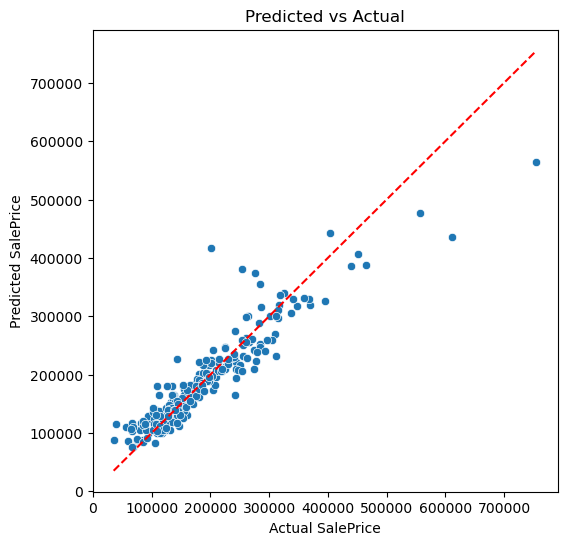

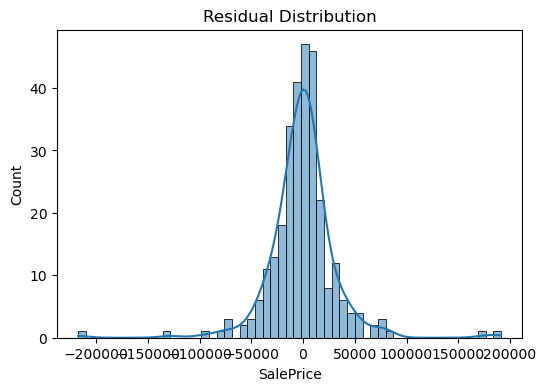

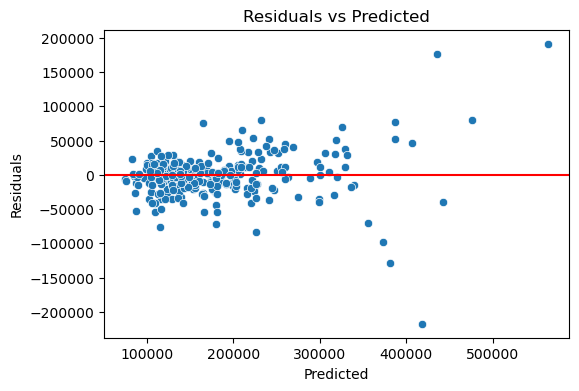

In [ ]:
# Predicted vs Actual Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Predicted vs Actual')
plt.show()

# Residual distribution
residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


Top Features:
1. SquareFeet (0.56556)
2. KitchenQuality (0.11816)
3. YearBuilt (0.06212)
4. AreaPerBedroom (0.05596)
5. HouseAge (0.04639)
6. HouseStyle (0.02426)
7. Neighborhood (0.01563)
8. LogLotSize (0.01374)
9. LotSize (0.01174)
10. Bedrooms (0.00705)


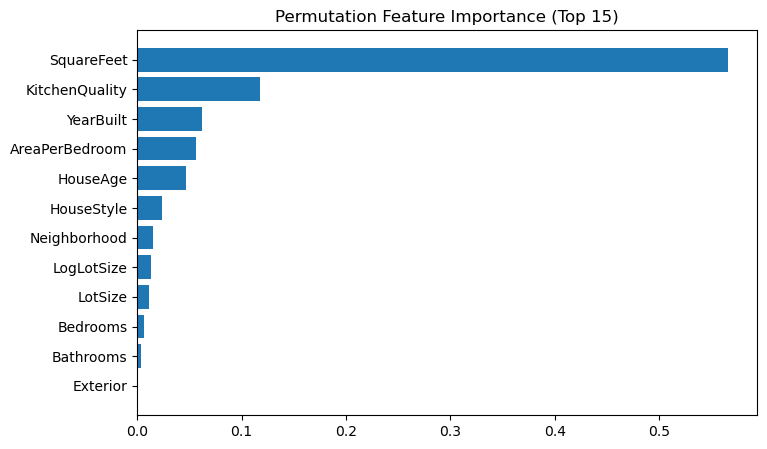

In [ ]:
# Permutation Importance
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_rf_pipeline, X_test, y_test,
    n_repeats=10, random_state=42
)

indices = r.importances_mean.argsort()[::-1]
feat_names = np.array(X_test.columns)[indices]

print("Top Features:")
for i in range(10):
    print(f"{i+1}. {feat_names[i]} ({r.importances_mean[indices[i]]:.5f})")

# Bar plot
plt.figure(figsize=(8,5))
plt.barh(feat_names[:15][::-1], r.importances_mean[indices][:15][::-1])
plt.title("Permutation Feature Importance (Top 15)")
plt.show()


In [ ]:
# SHAP Interpretability (optional)

try:
    import shap

    pre = best_rf_pipeline.named_steps['preprocessor']
    model = best_rf_pipeline.named_steps['rf']

    X_train_trans = pre.transform(X_train)

    explainer = shap.Explainer(model, X_train_trans)
    shap_values = explainer(X_train_trans)

    shap.summary_plot(shap_values, X_train_trans)

except Exception as e:
    print("SHAP not available:", e)


SHAP not available: No module named 'shap'


In [ ]:

models = {}

# 1. Linear Regression (baseline)
models["Linear Regression"] = baseline_model

# 2. Random Forest (default)
models["Random Forest (Default)"] = pipe_rf

# 3. Gradient Boosting
models["Gradient Boosting"] = pipe_gbr

# 4. Random Forest (Tuned — Final Model)
models["Random Forest (Tuned)"] = best_rf_pipeline

# Prepare summary storage
summary_rows = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model (for fairness)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Metrics
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics  = regression_metrics(y_test, y_test_pred)

    # Store in summary table
    summary_rows.append({
        "Model": name,

        "Train RMSE": train_metrics["RMSE"],
        "Test RMSE":  test_metrics["RMSE"],

        "Train MAE": train_metrics["MAE"],
        "Test MAE":  test_metrics["MAE"],

        "Train MAPE": train_metrics["MAPE(%)"],
        "Test MAPE":  test_metrics["MAPE(%)"],

        "Train R2": train_metrics["R2"],
        "Test R2":  test_metrics["R2"],
    })

# Convert to comparison DataFrame
evaluation_df = pd.DataFrame(summary_rows)

print("\n\n============================================")
print("📊 FINAL MODEL PERFORMANCE COMPARISON TABLE")
print("============================================")
display(evaluation_df.sort_values("Test RMSE"))



Training Linear Regression...

Training Random Forest (Default)...

Training Gradient Boosting...

Training Random Forest (Tuned)...


📊 FINAL MODEL PERFORMANCE COMPARISON TABLE


,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train MAPE,Test MAPE,Train R2,Test R2
2,Gradient Boosting,20587.496037,30489.340778,15427.657690,20297.340264,9.573485,13.251590,0.928939,0.878806
1,Random Forest (Default),11718.900981,32681.385611,7459.977582,19955.904255,4.451241,12.684408,0.976975,0.860753
3,Random Forest (Tuned),14169.289165,32838.676122,9046.059820,20159.098899,5.367778,12.796342,0.966340,0.859409
0,Linear Regression,33662.039246,38159.023301,21715.565246,23269.185906,12.689373,14.432958,0.810022,0.810163


In [27]:
# Safe error analysis

# Convert predictions into a Series aligned with X_test index
y_pred_series = pd.Series(y_pred_best, index=X_test.index)

# Calculate absolute errors
errors = (y_test - y_pred_series).abs()

# Worst cases (top 10 highest errors)
worst_idx = errors.sort_values(ascending=False).head(10).index

# Build table
worst_cases = X_test.loc[worst_idx].copy()
worst_cases["Actual"] = y_test.loc[worst_idx]
worst_cases["Predicted"] = y_pred_series.loc[worst_idx]
worst_cases["AbsError"] = errors.loc[worst_idx]

display(worst_cases.sort_values("AbsError", ascending=False))


,SquareFeet,Bedrooms,Bathrooms,YearBuilt,LotSize,Neighborhood,HouseStyle,Exterior,KitchenQuality,HouseAge,AreaPerBedroom,LogLotSize,Actual,Predicted,AbsError
1173,3086,3,3,1946,18030,ClearCr,1.5Fin,MetalSd,Ex,79,1028.666667,9.799848,200500,417794.862551,217294.862551
691,4316,4,3,1994,21535,NoRidge,2Story,HdBoard,Ex,31,1079.000000,9.977481,755000,563784.471880,191215.528120
898,2364,2,2,2009,12919,NridgHt,1Story,VinylSd,Ex,16,1182.000000,9.466532,611657,435630.832897,176026.167103
581,2042,3,2,2008,12704,NridgHt,1Story,VinylSd,Ex,17,680.666667,9.449751,253293,381642.037286,128349.037286
261,2574,3,2,2007,9588,CollgCr,2Story,CemntBd,Ex,18,858.000000,9.168372,276000,373629.405590,97629.405590
588,1473,1,1,1968,25095,ClearCr,1Story,Wd Sdng,Ex,57,1473.000000,10.130464,143000,226279.188461,83279.188461
1046,2868,4,3,2005,16056,StoneBr,2Story,CemntBd,Ex,20,717.000000,9.683900,556581,476485.008915,80095.991085
218,1954,3,1,1939,15660,Crawfor,1.5Fin,VinylSd,Gd,86,651.333333,9.658929,311500,232001.553285,79498.446715
1243,2076,2,2,2006,13891,NridgHt,1Story,VinylSd,Ex,19,1038.000000,9.539068,465000,387328.667542,77671.332458
271,1363,2,1,1954,39104,ClearCr,1Story,Plywood,TA,71,681.500000,10.574006,241500,165701.536306,75798.463694
